In [177]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

In [178]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,
                                                      'steering': np.float32,'throttle': np.float32,
                                                      'brake': np.float32,'speed': np.float32},
                   skipinitialspace=1)
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

center = data['center']
left = data['left']
right = data['right']
steering = data['steering']
throttle = data['throttle']
speed=data['speed']
brake=data['brake']
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Training throttle size = ',len(throttle))
print('Training speed size = ',len(speed))

print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Training throttle size =  8036
Training speed size =  8036
Data loaded


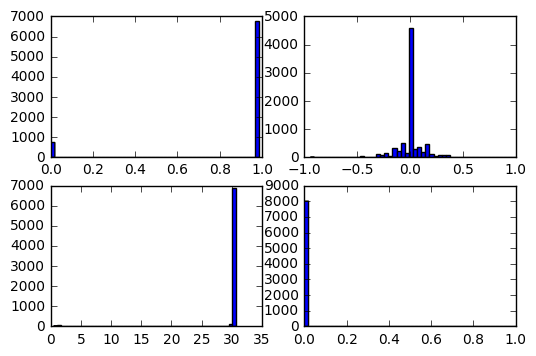

1.0
0.985533


In [179]:
# examine the data
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
plt.hist(throttle,50)
ax = fig.add_subplot(2,2,2)
plt.hist(steering,50)
ax = fig.add_subplot(2,2,3)
plt.hist(speed,50)
ax = fig.add_subplot(2,2,4)
plt.hist(brake,50)
plt.show()
print(max(brake))
print(max(throttle))

In [185]:
import numpy as np

def rotate_image(image, angle):
    radians = angle*math.pi/180
    (height, width, channels) = image.shape
    rot_mat = cv2.getRotationMatrix2D((width/2,height/2),angle,1.0)
    return cv2.warpAffine(image, rot_mat, (width, height),flags=cv2.INTER_LINEAR),radians

def shift_and_crop (filename,steering,direction,amount):
    img = cv2.imread(filename)
    (rows,cols,channels) = img.shape
    if direction == 'l' or direction == 'left':
        M = np.float32([[1,0,-amount],[0,1,0]]) # REMEMBER TO ADD STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering-amount/100.0
    else:
        M = np.float32([[1,0,amount],[0,1,0]]) # REMEMBER TO ADD STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering+amount/100.0
    
    return crop_img, steering

def crop_image(dst): 
    crop_img = dst[60:140, 10:310] # original size 320 x 160, final size 300 x 80crop_img
    return crop_img

print('crop_images function defined')

crop_images function defined


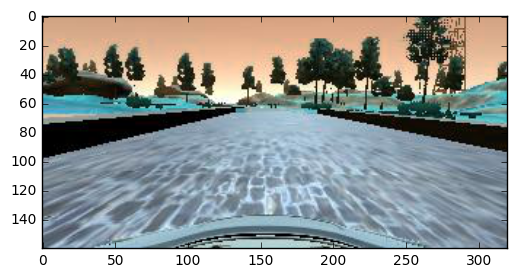

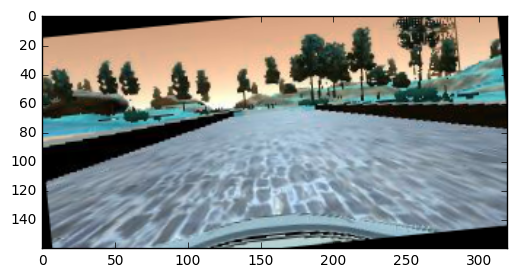

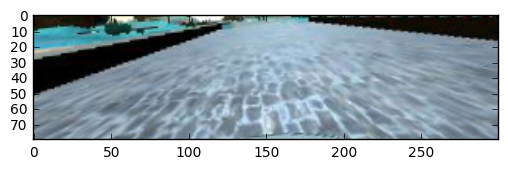

In [186]:
#test rotate image
img = cv2.imread('./data/data/'+X_train[0])

plt.imshow(img)
plt.show()
img_rot,img_st = rotate_image(img,0.1*180/math.pi)
plt.imshow(img_rot)
plt.show()

#test crop image
crop_img = crop_image(img_rot)
plt.imshow(crop_img)
plt.show()


In [187]:
def to_binary(img):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    thresh = (5, 60)
    binary_S = np.zeros_like(S)
    binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
#     plt.imshow(binary_S,'gray')
#     plt.show()

    thresh = (10,40)
    binary_H = np.zeros_like(H)
    binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1
#     plt.imshow(binary_H,'gray')
#     plt.show()

    binary = np.zeros_like(S)
    binary[(binary_H>0.5) & (binary_S>0.5)] = 1
#     plt.imshow(binary,'gray')
#     plt.show()
    return binary    

In [188]:
# augment data by:
# 1) using all images, center, left and righ 
#     a) crop all images to relevant section (remove car and sky) 
# 2) duplicate and flip images (invert steering)
#     a) crop
# 3) shift images to left and right 
# of all above just save those which fall under the desired probability

import random
import sys

random.seed()
count = 0
offset = 0.1 #steering offset for left and right cameras
print('Saving augmented images. Please wait...')
logfile = open('./data/new_data/new_log.csv','a')
num_iter = len(center)

for i in range(num_iter):
    if abs(steering[i])<0.0001 or brake[i]>0 or speed[i]<5 or throttle[i]<0.5:
        continue
#for i in range(10):
    # 1) using all images, center, left and righ
    new_images = []
    new_steering = []
#     a) crop all images to relevant section (remove car and sky) 

    #center camera
    filename = 'data/data/'+center[i]
    img = cv2.imread(filename)
    
    crop_img = crop_image(img)
    new_images.append(crop_img)
    new_steering.append (steering[i])
    
#     rot_img,rot_st = rotate_image(img, -7)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
#     rot_img,rot_st = rotate_image(img, -5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
#     rot_img,rot_st = rotate_image(img, -3)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
#     rot_img,rot_st = rotate_image(img, 3)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
#     rot_img,rot_st = rotate_image(img, 5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
#     rot_img,rot_st = rotate_image(img, 7)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st)
    
    for k in range(5):
        new_img, new_st = shift_and_crop (filename,steering[i],'left',-15+k*3)
        new_images.append(new_img)
        new_steering.append(new_st)
        
        new_img, new_st = shift_and_crop (filename,steering[i],'left',15-k*3)
        new_images.append(new_img)
        new_steering.append(new_st)
    
    #left camera
#     filename = 'data/data/'+left[i]
#     new_steering.append(steering[i]+offset)
#     img = cv2.imread(filename)
#     crop_img = crop_image(img)
#     new_images.append(crop_img)
    
#     rot_img,rot_st = rotate_image(img, 5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st+offset)
    
#     rot_img,rot_st = rotate_image(img, -5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st+offset)
    
#     new_img, new_st = shift_and_crop (filename,steering[i]+offset,'left')
#     new_images.append(new_img)
#     new_steering.append(new_st)
    
#     new_img, new_st = shift_and_crop (filename,steering[i]+offset,'right')
#     new_images.append(new_img)
#     new_steering.append(new_st)
    
    #right camera
#     filename = 'data/data/'+right[i]
#     new_steering.append(steering[i]-offset)
#     img = cv2.imread(filename)
#     crop_img = crop_image(img)
#     new_images.append(crop_img)

#     rot_img,rot_st = rotate_image(img, 5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st-offset)
    
#     rot_img,rot_st = rotate_image(img, -5)
#     crop_img = crop_image(rot_img)
#     new_images.append(crop_img)
#     new_steering.append(rot_st-offset)
    
#     new_img, new_st = shift_and_crop (filename,steering[i]-offset,'left')
#     new_images.append(new_img)
#     new_steering.append(new_st)
    
#     new_img, new_st = shift_and_crop (filename,steering[i]-offset,'right')
#     new_images.append(new_img)
#     new_steering.append(new_st)
#     assert (len(new_images)==15)
    
    for j in range(len(new_images)):
        # add flipped images
        new_images.append(cv2.flip(new_images[j],1))
        new_steering.append((new_steering[j])*(-1))

    assert (len(new_images)==22)
    
    # save according to the probability
    # higher steering have higher probability of being saved
    
    for j in range(len(new_images)):
        rand_num = random.random()
        #print(rand_num,',',abs(new_steering[j]))
        if (abs(new_steering[j])+0.02)>=rand_num:
            #save this image to the final set    
            filename = 'IMG/image_'+str(count)+'.jpg'
            count = count+1
            cv2.imwrite('data/new_data/'+filename,new_images[j])
            logfile.write(filename+','+str(new_steering[j])+'\n')
                         
logfile.close()

print('Total images saved:',count)

Saving augmented images. Please wait...
Total images saved: 13626


(160, 320, 3)


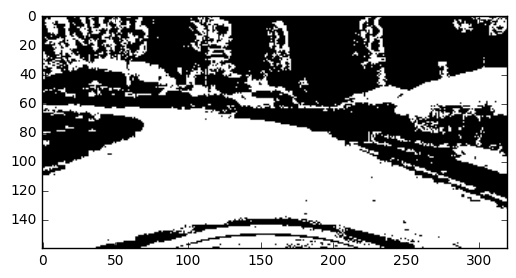

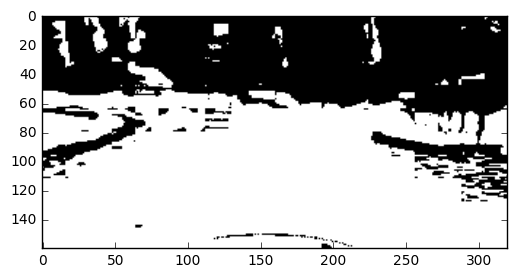

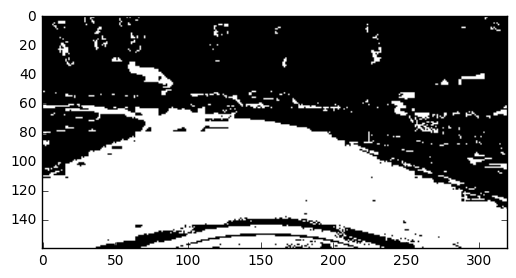

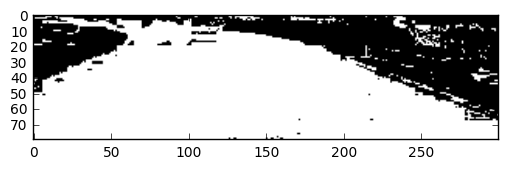

In [126]:
i=10
filename = 'data/data/'+center[i]
new_steering.append (steering[i])
img = cv2.imread(filename)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
print(img.shape)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (5, 60)
binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary_S,'gray')
plt.show()

thresh = (10,40)
binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1
plt.imshow(binary_H,'gray')
plt.show()

binary = np.zeros_like(S)
binary[(binary_H>0.5) & (binary_S>0.5)] = 1
plt.imshow(binary,'gray')
plt.show()

crop_img = crop_image(binary)
plt.imshow(crop_img,'gray')
plt.show()